<a href="https://colab.research.google.com/github/sultanbst123/MachineHack-Dare_in_reality/blob/main/Dare_in_reality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data modelling with Python

## Library & File

In [ ]:

!pip install catboost
!pip install optuna
!pip install borutashap

In [ ]:
!pip install --upgrade scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from BorutaShap import BorutaShap
 
# classification
import lightgbm, catboost
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# regression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

#preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,f1_score, 
                            log_loss, roc_auc_score, plot_roc_curve,plot_confusion_matrix) 
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
from sklearn.preprocessing import LabelEncoder,OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.calibration import CalibrationDisplay

import warnings
warnings.filterwarnings("ignore")
 
%matplotlib inline

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Dare in reality/train_dir(clean).csv") 
test = pd.read_csv("/content/drive/MyDrive/Dare in reality/test_dir(clean).csv")
sub = pd.read_csv("/content/drive/MyDrive/Dare in reality/submission.csv")

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10276 entries, 0 to 10275
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0    LAP_NUMBER      10276 non-null  int64  
 1   LAP_TIME         10276 non-null  int64  
 2    KPH             10246 non-null  float64
 3    ELAPSED         10276 non-null  object 
 4    HOUR            10276 non-null  object 
 5   S1_LARGE         10272 non-null  object 
 6   S2_LARGE         10268 non-null  object 
 7   S3_LARGE         10242 non-null  object 
 8   GROUP            10276 non-null  object 
 9   TEAM             10276 non-null  object 
 10  LOCATION         10276 non-null  object 
 11  EVENT            10276 non-null  object 
 12  AIR_TEMP         10276 non-null  int64  
 13  TRACK_TEMP       10276 non-null  int64  
 14  HUMIDITY         10276 non-null  int64  
 15  WIND_SPEED       10276 non-null  int64  
 16  WIND_DIRECTION   10276 non-null  float64
 17  RAIN        

In [ ]:
train.head()

,LAP_NUMBER,LAP_TIME,KPH,ELAPSED,HOUR,S1_LARGE,S2_LARGE,S3_LARGE,GROUP,TEAM,LOCATION,EVENT,AIR_TEMP,TRACK_TEMP,HUMIDITY,WIND_SPEED,WIND_DIRECTION,RAIN,PIT?,DRIVER,ALL_IMPROVEMENT,POWER?
0,1,92,28.8,07:02.0,22:02.0,05:43.3,00:35.4,00:43.3,none,JR,Location 2,Free Practice 2,12,12,65,2,149.0,-1,yes,SB_10,0.0,no
1,2,87,120.5,08:43.0,23:43.0,00:25.7,00:33.4,00:41.9,none,JR,Location 2,Free Practice 2,12,12,65,2,149.0,-1,no,SB_10,2.0,no
2,3,73,101.9,10:42.5,25:42.5,00:28.1,00:34.1,00:57.2,none,JR,Location 2,Free Practice 2,12,12,65,2,149.0,-1,no,SB_10,0.0,no
3,1,73,75.9,02:40.2,17:40.2,01:05.0,00:38.4,00:56.8,none,AD,Location 2,Free Practice 2,12,12,65,2,149.0,-1,yes,LGRA_11,0.0,no
4,2,73,111.2,04:29.7,19:29.7,00:28.0,00:36.7,00:44.7,none,AD,Location 2,Free Practice 2,12,12,65,2,149.0,-1,no,LGRA_11,0.0,no


In [ ]:

#drop lap time di test 

test.drop("LAP_TIME", axis=1, inplace=True)

## split

In [ ]:
x = train.drop("LAP_TIME", axis=1) 
y = train.LAP_TIME

In [ ]:
cater = x.select_dtypes(exclude="number").columns

In [ ]:

# ubah ke type category
x[cater] = x[cater].astype("category")

In [ ]:
x_train,x_val,y_train,y_val = train_test_split(x, y, test_size=0.1, random_state=43)

In [ ]:
## coba dengan lgbm 

lg = LGBMRegressor(random_state=42) 
lg.fit(x_train, y_train)

LGBMRegressor(random_state=42)

In [ ]:
pred = lg.predict(x_val)

In [ ]:
print(f"r2_score train: {lg.score(x_train,y_train) }")
print(f"r2_score val: {lg.score(x_val,y_val) }")
print(f"RMSLE : {mean_squared_log_error(y_val,pred, squared=False)}")
print(f"MAE : {mean_absolute_error(y_val,pred)}")

r2_score train: 0.6084054716791907
r2_score val: -0.015992623475143963
RMSLE : 0.530794946056586
MAE : 18.157528180284253


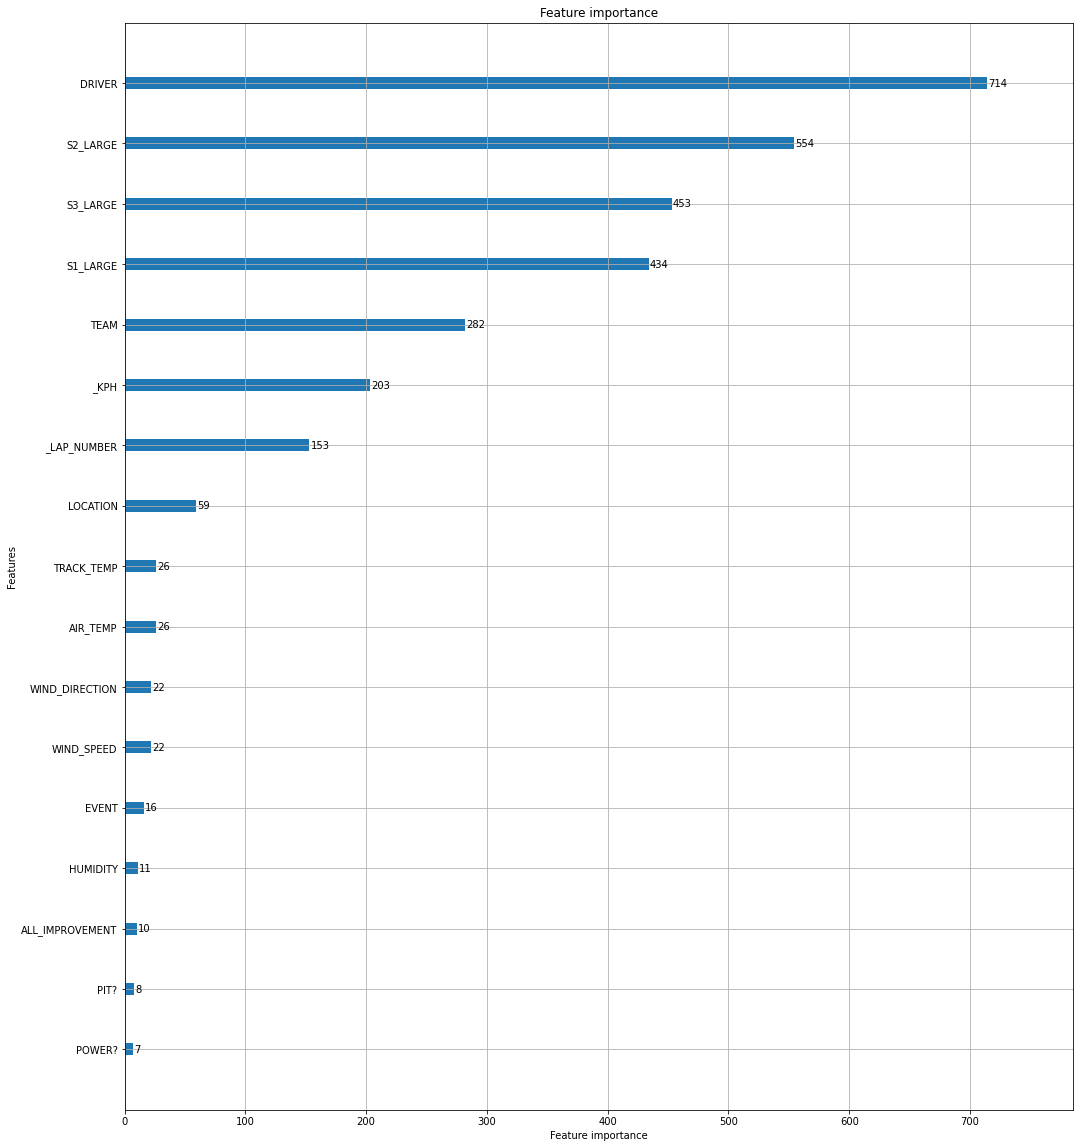

In [ ]:

# check important feature

fig, ax = plt.subplots(1, 1,figsize=(17,20)) 

lightgbm.plot_importance(lg,ax=ax)

## feature selection

In [ ]:
fs = BorutaShap(model=lg,
                importance_measure="shap",
                classification = False)

In [ ]:
fs.fit(X=x_train, y=y_train, n_trials=10,random_state=0)

Warning there are missing values in your data !


  0%|          | 0/10 [00:00<?, ?it/s]

1 attributes confirmed important: ['LOCATION']
19 attributes confirmed unimportant: ['S1_LARGE', 'WIND_SPEED', ' KPH', ' LAP_NUMBER', 'PIT?', 'RAIN', ' HOUR', 'HUMIDITY', 'S3_LARGE', 'WIND_DIRECTION', 'EVENT', 'AIR_TEMP', 'ALL_IMPROVEMENT', ' ELAPSED', 'TEAM', 'GROUP', 'TRACK_TEMP', 'POWER?', 'DRIVER']
1 tentative attributes remains: ['S2_LARGE']


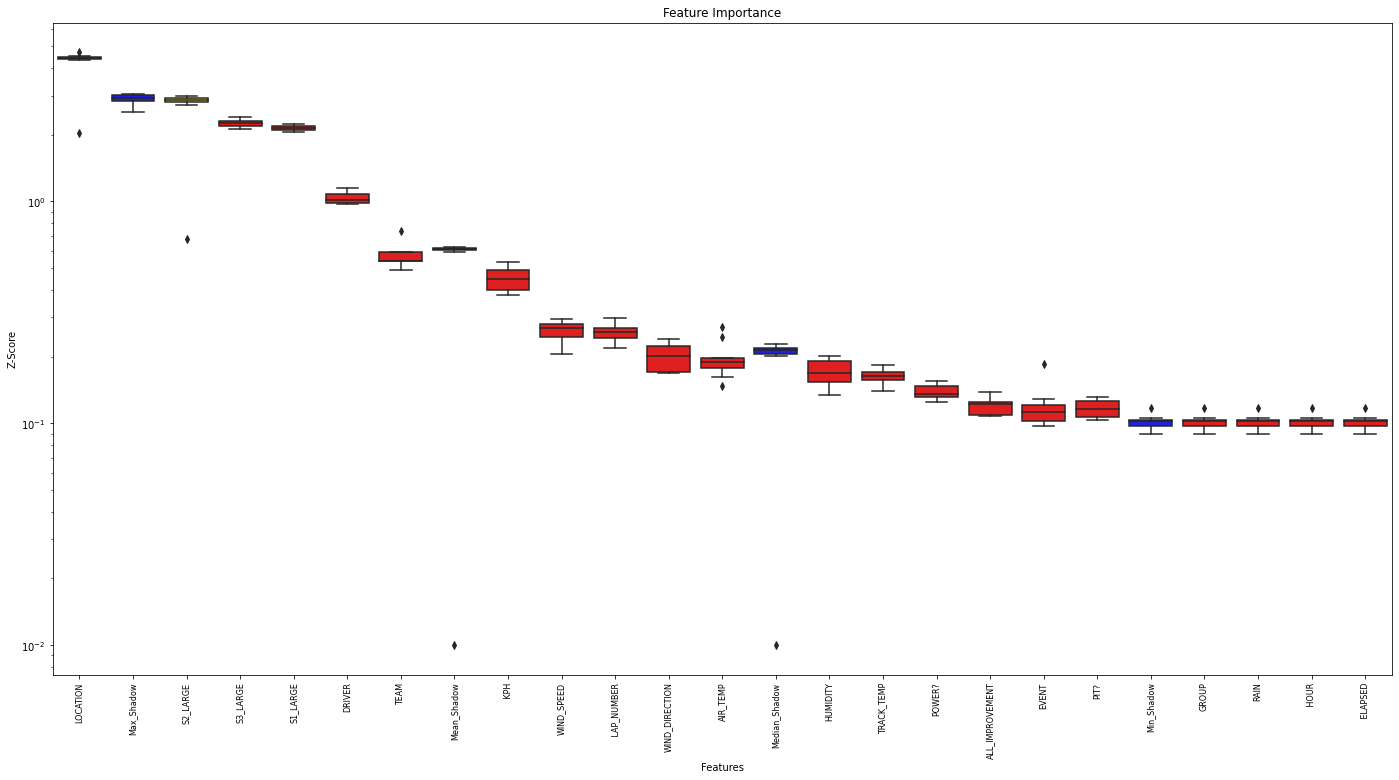

In [ ]:
fs.plot(which_features='all', figsize=(24,12))

In [ ]:
col = fs.Subset().columns.to_list()
col

['LOCATION']

In [ ]:
col = ['LOCATION',"DRIVER"]

## Hyper parameters tuning, lgbm & catboost

### Catboost

In [ ]:
def objective(trial):
    
    params = {#'loss_function':'RMSE',              
              #'eval_metric':'Accuracy',
              #task_type : trial.suggest_categorical("task_type",["GPU"]),
              'boosting_type': trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),            
              'bootstrap_type':trial.suggest_categorical("bootstrap_type",["Bernoulli"]), #"MVS"]),#"Bayesian" 
              'iterations':trial.suggest_categorical("iterations", [10000]),
              'od_wait':trial.suggest_int('od_wait', 500, 2000), 
              'random_strength': trial.suggest_uniform('random_strength',10,50),                           
              'learning_rate' : trial.suggest_uniform('learning_rate',0.01,1.0),
              'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
              'subsample': trial.suggest_uniform('subsample',0,1),
              'depth': trial.suggest_int('depth',1,10),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
              'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
               }

    model = CatBoostRegressor(**params)  
    model.fit(x_train[col],y_train,eval_set=[(x_val[col],y_val)],verbose=False,early_stopping_rounds=100, 
              cat_features = col) #catfeatures for category cols
        
    y_preds = model.predict(x_val[col])   
    rmsle = mean_squared_log_error(y_val, y_preds,squared=False)

    return rmsle

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2021-11-22 07:53:12,406] A new study created in memory with name: no-name-8f6ca605-d215-4785-99a3-531b0bfe3d5b
[I 2021-11-22 07:53:12,683] Trial 0 finished with value: 0.5204473940937031 and parameters: {'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'iterations': 10000, 'od_wait': 1880, 'random_strength': 30.274211470215274, 'learning_rate': 0.9472260938575495, 'reg_lambda': 36.22570373068032, 'subsample': 0.26505496962818953, 'depth': 3, 'min_data_in_leaf': 19, 'leaf_estimation_iterations': 2}. Best is trial 0 with value: 0.5204473940937031.
[I 2021-11-22 07:53:13,100] Trial 1 finished with value: 0.5206683084239906 and parameters: {'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'iterations': 10000, 'od_wait': 710, 'random_strength': 20.603555039019717, 'learning_rate': 0.8813967756678207, 'reg_lambda': 1.2678795183493015, 'subsample': 0.003863730793541409, 'depth': 5, 'min_data_in_leaf': 22, 'leaf_estimation_iterations': 3}. Best is trial 0 with value: 0.520

In [ ]:
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

Number of finished trials: 100
Best trial: {'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'iterations': 10000, 'od_wait': 1246, 'random_strength': 11.29077225966216, 'learning_rate': 0.7544184055094013, 'reg_lambda': 54.8068068880185, 'subsample': 0.5886905126586024, 'depth': 10, 'min_data_in_leaf': 23, 'leaf_estimation_iterations': 15}


In [ ]:
cb_params = study.best_trial.params
cb_params

{'boosting_type': 'Plain',
 'bootstrap_type': 'Bernoulli',
 'depth': 10,
 'iterations': 10000,
 'leaf_estimation_iterations': 15,
 'learning_rate': 0.7544184055094013,
 'min_data_in_leaf': 23,
 'od_wait': 1246,
 'random_strength': 11.29077225966216,
 'reg_lambda': 54.8068068880185,
 'subsample': 0.5886905126586024}

### LGBM

In [ ]:
#lgbm
def objective(trial):
    params = {
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),
        'objective': trial.suggest_categorical('objective',['regression','rmse']),#'multiclass','binary']),  
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.95, step=0.1),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1),
    }
    model = LGBMRegressor(**params)  
    model.fit(x_train[col],y_train,eval_set=[(x_val[col],y_val)],verbose=False,early_stopping_rounds=100) 
              
    y_preds = model.predict(x_val[col])   
    rmsle = mean_squared_log_error(y_val, y_preds,squared=False)

    return rmsle

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2021-11-22 07:52:20,438] A new study created in memory with name: no-name-5d8019d4-bf8b-4952-a089-6b5aed067d24
[I 2021-11-22 07:52:20,511] Trial 0 finished with value: 0.5407590847247465 and parameters: {'objective': 'rmse', 'n_estimators': 10000, 'learning_rate': 0.11110043449160592, 'num_leaves': 2140, 'max_depth': 3, 'min_data_in_leaf': 5300, 'lambda_l1': 50, 'lambda_l2': 30, 'min_gain_to_split': 7.509846941877318, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: 0.5407590847247465.
[I 2021-11-22 07:52:20,672] Trial 1 finished with value: 0.5196052788137597 and parameters: {'objective': 'rmse', 'n_estimators': 10000, 'learning_rate': 0.08170442538779904, 'num_leaves': 840, 'max_depth': 4, 'min_data_in_leaf': 2900, 'lambda_l1': 15, 'lambda_l2': 55, 'min_gain_to_split': 11.194083279808188, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 1 with value: 0.5196052788137597

In [ ]:

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

Number of finished trials: 100
Best trial: {'objective': 'regression', 'n_estimators': 10000, 'learning_rate': 0.29713788123351326, 'num_leaves': 180, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 85, 'lambda_l2': 65, 'min_gain_to_split': 2.37788149093947, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.4}


In [ ]:
lgbm_params = study.best_trial.params
lgbm_params

{'bagging_fraction': 0.30000000000000004,
 'bagging_freq': 1,
 'feature_fraction': 0.4,
 'lambda_l1': 85,
 'lambda_l2': 65,
 'learning_rate': 0.29713788123351326,
 'max_depth': 9,
 'min_data_in_leaf': 200,
 'min_gain_to_split': 2.37788149093947,
 'n_estimators': 10000,
 'num_leaves': 180,
 'objective': 'regression'}

## Cross validation

### LGBM

In [ ]:
# Cross validation for lgbm

def cross_val(X, y, model, params, folds=5):

    score = []
    
    skf = KFold(n_splits=folds, shuffle=True, random_state=21)

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        print(f"Fold: {fold+1}")
        x_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        x_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        
        #fit
        alg = model(**params,random_state=2021)
        alg.fit(x_train,y_train,eval_set=[(x_test,y_test)],verbose=False,early_stopping_rounds=100)

        #predict validation
        pred = alg.predict(x_test)
        error = mean_squared_log_error(y_test, pred,squared=False)
        score.append(error)
        
        print(f" RMSLE: {error}")
        print("-"*50)
     
    print("\nmean RMSLE:",np.array(score).mean())

    return alg

In [ ]:

# buat df baru berdasarkan feature selection

x_new = train[["LOCATION", "DRIVER"]].astype("category") 
y_new = y

In [ ]:
lgbm_score = cross_val(x_new, y_new, LGBMRegressor, lgbm_params)

Fold: 1
 RMSLE: 0.5697774953935589
--------------------------------------------------
Fold: 2
 RMSLE: 0.5472769814895292
--------------------------------------------------
Fold: 3
 RMSLE: 0.5847654358627524
--------------------------------------------------
Fold: 4
 RMSLE: 0.5738923619444863
--------------------------------------------------
Fold: 5
 RMSLE: 0.5318017693092141
--------------------------------------------------

mean RMSLE: 0.5615028087999082


In [ ]:
lgbm_predict = lgbm_score.predict(x_val[col])

Text(0, 0.5, 'Predict')

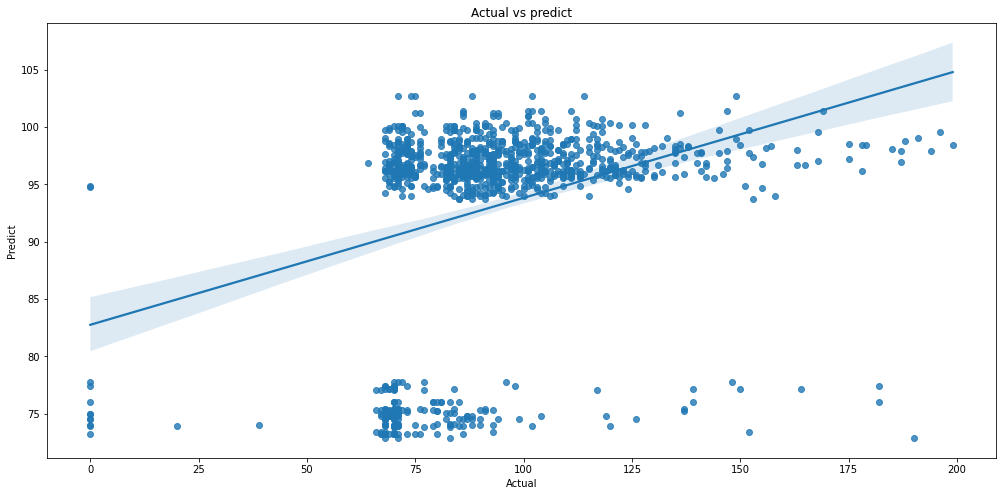

In [ ]:
plt.figure(figsize=(17, 8)) 

sns.regplot(y_val, lgbm_predict)
plt.title("Actual vs predict")
plt.xlabel("Actual")
plt.ylabel("Predict")

In [ ]:
print(f"r2_score train: {lgbm_score.score(x_train[col],y_train) }")
print(f"r2_score val: {lgbm_score.score(x_val[col],y_val) }")
print(f"RMSLE : {mean_squared_log_error(y_val,lgbm_predict, squared=False)}")
print(f"MAE : {mean_absolute_error(y_val,lgbm_predict)}")

r2_score train: 0.10702636370816698
r2_score val: 0.10718614867220355
RMSLE : 0.5193213831316138
MAE : 16.82687264395561


### Catboost

In [ ]:
# Cross validation for lgbm

def cross_val(X, y, model, params, folds=5):

    score = []
    
    skf = KFold(n_splits=folds, shuffle=True, random_state=21)

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        print(f"Fold: {fold+1}")
        x_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        x_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        
        #fit
        alg = model(**params,random_state=2021)
        alg.fit(x_train,y_train,eval_set=[(x_test,y_test)],verbose=False,cat_features=col,early_stopping_rounds=100)

        #predict validation
        pred = alg.predict(x_test)
        error = mean_squared_log_error(y_test, pred,squared=False)
        score.append(error)
        
        print(f" RMSLE: {error}")
        print("-"*50)
     
    print("\nmean RMSLE:",np.array(score).mean())

    return alg

In [ ]:
cb_score = cross_val(x_new, y_new, CatBoostRegressor, cb_params)

Fold: 1
 RMSLE: 0.5710865770824677
--------------------------------------------------
Fold: 2
 RMSLE: 0.5473814505254019
--------------------------------------------------
Fold: 3
 RMSLE: 0.5865740489236189
--------------------------------------------------
Fold: 4
 RMSLE: 0.575056004835865
--------------------------------------------------
Fold: 5
 RMSLE: 0.5312914902186728
--------------------------------------------------

mean RMSLE: 0.5622779143172052


In [ ]:
cb_predict = cb_score.predict(x_val[col])

Text(0, 0.5, 'Predict')

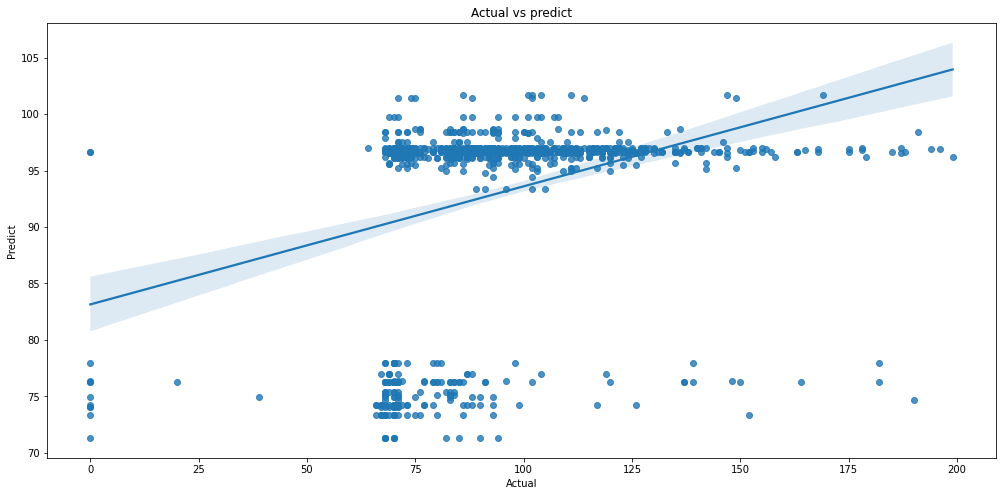

In [ ]:
plt.figure(figsize=(17, 8)) 

sns.regplot(y_val, cb_predict)
plt.title("Actual vs predict")
plt.xlabel("Actual")
plt.ylabel("Predict")

In [ ]:
print(f"r2_score train: {cb_score.score(x_train[col],y_train) }")
print(f"r2_score val: {cb_score.score(x_val[col],y_val) }")
print(f"RMSLE : {mean_squared_log_error(y_val,cb_predict, squared=False)}")
print(f"MAE : {mean_absolute_error(y_val,cb_predict)}")

r2_score train: 0.10564234974067055
r2_score val: 0.10054232887298176
RMSLE : 0.519618062445021
MAE : 16.869630473681188


## Buat submission

In [ ]:
sub

,LAP_TIME
0,0
1,0
2,0
3,0
4,0
...,...
415,0
416,0
417,0
418,0


In [ ]:
tester = test[col].astype("category")

In [ ]:
y_true = lgbm_score.predict(tester)

In [ ]:
y_true

array([ 97.51843914,  97.51843914,  97.51843914,  97.40068328,
        97.40068328,  97.40068328, 100.21062619, 100.21062619,
       100.21062619,  95.66464871,  95.66464871,  95.66464871,
        99.91709129,  99.91709129,  99.91709129,  96.98812532,
        96.98812532,  96.98812532,  97.68216013,  97.68216013,
        97.68216013,  97.79294668,  97.79294668,  97.79294668,
        98.51773223,  98.51773223,  98.51773223,  98.50563246,
        98.50563246,  98.50563246,  97.0105016 ,  97.0105016 ,
        97.0105016 ,  96.48256118,  96.48256118,  96.48256118,
        97.85144251,  97.85144251,  97.85144251,  96.59206942,
        96.59206942,  96.59206942,  96.32632568,  96.32632568,
        96.32632568,  97.27321345,  97.27321345,  97.27321345,
        97.59362061,  97.59362061,  97.59362061,  99.5251056 ,
        99.5251056 ,  99.5251056 ,  95.34033293,  95.34033293,
        95.34033293,  97.90846592,  97.90846592,  97.90846592,
        95.89133924,  95.89133924,  95.89133924,  96.41

In [ ]:
sub["LAP_TIME"] = y_true.round()

In [ ]:
sub["LAP_TIME"] = sub["LAP_TIME"].astype("int")

In [ ]:
sub

,LAP_TIME
0,98
1,98
2,98
3,97
4,97
...,...
415,73
416,75
417,75
418,74


In [ ]:
sub.to_csv("sub_last_3.csv", index=False)